# Fitting a scaled LDA model via proximal gradient descent
_Date:_ September 17, 2024

**Background.**
Latent Dirichlet allocation (LDA) assumes that all words in a document are distributed with identical dispersion.

In many cases, however, the assumption of similar dispersion of all words in the vocabulary is unrealistic.
This is evidenced in the need to preprocess the input texts and remove highly used words such as articles (e.g. the, a) and conjunctions (e.g. and, for).

One way to account for the differences in dispersion in different words, while retaining the the interpretation of $\mathbf{\theta}$ as topics and $\beta_m$ as the topic usages in a document,
is to explicitly model different dispersions for the different words. We refer to this model as a scaled LDA model.


**Algorithm.** TODO

In [1]:
from functools import partial

import jax
from jax import jit, grad, lax, vmap
import jax.numpy as jnp
import jax.random as jr

from scipy.spatial.distance import cdist 
from scipy.optimize import linear_sum_assignment

from sklearn.decomposition import LatentDirichletAllocation as LDA

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import matplotlib.pyplot as plt
import seaborn as sns

## Proximal gradient descent

### Generic PGD with backtracking line search

In [2]:
def prox_grad_descent(objective,
                      prox,
                      init_params,
                      max_num_steps=100,
                      max_num_backtrack_steps=100,
                      max_stepsize=1.0,
                      discount=0.9,
                      tol=1e-6,
                      verbosity=0):
    r""" Run proximal gradient descent on an objective using the given
    proximal operator.

    prox: params x stepsize -> new_params
    """
    # We need the gradient of the objective
    g = jit(objective)
    dg = jit(grad(objective))

    # Run proximal gradient descent until convergence
    def _step_cond(state):
        _, old_obj, curr_obj, counter = state
        return (abs(curr_obj - old_obj) > tol) & (counter <= max_num_steps)

    def _step_body(state):
        params, _, curr_obj, counter = state

        # Define the condition and body of a while loop for backtracking line search
        def _backtrack_cond(backtrack_state):
            stepsize, backtrack_counter = backtrack_state

            # Compute generalized gradient
            G = (params - prox(params - stepsize * dg(params), stepsize)) / stepsize

            # Update params and evaluate objective
            new_params = params - stepsize * G
            new_obj = g(new_params)

            # Compute upper bound on objective via quadratic Taylor approx
            lower_bound = g(params) \
                - stepsize * jnp.sum(dg(params) * G) \
                    + 0.5 * stepsize * jnp.sum(G**2)

            # Continue to decrease stepsize while objective exceeds lower bound
            return (new_obj > lower_bound) & (backtrack_counter < max_num_backtrack_steps)

        def _backtrack_body(backtrack_state):
            stepsize, backtrack_counter = backtrack_state
            return stepsize * discount, backtrack_counter + 1

        # Run backtracking line search to find stepsize
        stepsize, _ = lax.while_loop(_backtrack_cond, _backtrack_body, (max_stepsize, 0))

        # Perform update with this stepsize
        G = (params - prox(params - stepsize * dg(params), stepsize)) / stepsize
        new_params = params - stepsize * G
        new_obj = g(new_params)
        return new_params, curr_obj, new_obj, counter + 1

    params, _, _, n_steps = lax.while_loop(_step_cond, _step_body, (init_params, jnp.inf, 0.0, 0))
    return params

### Proximal operator to project onto the simplex

In [3]:
@jit
def _simplex_lagrangian(w, lmbda):
    return jnp.sum(jnp.clip(w - lmbda, a_min=0.0)) - 1.0


def bisect_jax(f, a, b, tol=1e-6, max_iter=50):
    """Find a root of f via bisection.

    Args:
        f: a function that is monotonically increasing or decreasing on the interval [a, b]
        a: lower bound on root
        b: upper bound on root
    """
    def _bisect_cond(state):
        (a, f_a), (b, f_b), counter = state
        # m = (a + b) / 2
        return (abs(f(a)) > tol) & ((b - a) / 2 > tol) & (counter < max_iter)

    def _bisect_body(state):
        (a, f_a), (b, f_b), counter = state
        m = (a + b) / 2
        f_m = f(m)
        # if sign(f(m)) = sign(f(m)) then a <- m else b <- m // new interval
        state = lax.cond(jnp.sign(f_m) == jnp.sign(f_a),
                        lambda: ((m, f_m), (b, f_b), counter+1), # predicate true
                        lambda: ((a, f_a), (m, f_m), counter+1), # predicate false
                        )
        return state

    init_state = ((a, f(a)), (b, f(b)), 0)
    ((a, fa), (b, fb), counter) = lax.while_loop(_bisect_cond, _bisect_body, init_state)
    # print("num iters: ", counter)
    return a


def project_simplex(w, dummy_stepsize):
    """Project onto simplex following the approach in Ch 6.2.5 of
    https://web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf
    """
    lmbda_max = jnp.max(w)
    lmbda_star = bisect_jax(partial(_simplex_lagrangian, w),
                            lmbda_max - 1, lmbda_max)
    return jnp.clip(w - lmbda_star, a_min=0.0)

In [4]:
# Test it on some inputs
for w in [
    jnp.array([0.2, 0.9, 1.4]),  # not on the simplex, positive inputs
    jnp.array([-0.4, 0.9, 0.2]),  # not on the simplex, negative inputs
    jnp.array([0.33, 0.33, 0.33]),  # simplex vector 
    jnp.array([3.3, 3.3, 3.3]),  # scaled version of a simplex vectro
]:
    what = project_simplex(w, 0)
    print(w, '->', what)
    assert jnp.all(what >= 0) & jnp.isclose(what.sum(), 1.0)

2024-09-27 17:29:47.814612: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


[0.2 0.9 1.4] -> [0.        0.2500019 0.7500019]
[-0.4  0.9  0.2] -> [0.         0.8500004  0.15000041]
[0.33 0.33 0.33] -> [0.33333397 0.33333397 0.33333397]
[3.3 3.3 3.3] -> [0.33333397 0.33333397 0.33333397]


### Minimize a sum of gamma negative log likelihoods

In [5]:
objective = lambda x, shapes, rates: \
    -1.0 * tfd.Gamma(shapes, rate=rates).log_prob(jnp.clip(x, a_min=1e-4)).sum()

First, we consider the special case of equal rates, $\beta \equiv \beta_i = \beta_j \forall i,j \in K$. In this case, the optimal parameter under both the Dirichlet and indepedent Gamma distributions are the same, up to a multiplicative constant. Specifically,
\begin{align*}
x_i^\star &\leftarrow \left(\arg\max_x \log \textrm{Dir}(x \mid \mathbf{\alpha})\right)_i = \frac{\alpha_i-1}{\sum_j (\alpha_j-1)} \\
y_i^\star &\leftarrow \left(\arg\max_y \log \textrm{Gamma}(x \mid \mathbf{\alpha}, \mathbf{\beta})\right)_i = \frac{\alpha_i-1}{\beta}.
\end{align*}
We also note that
$$
\frac{y_i^\star}{\sum_j y_j^\star} = \frac{\frac{\alpha_i-1}{\beta}}{\sum_j \frac{\alpha_j-1}{\beta}} = \frac{\alpha_i-1}{\sum_j (\alpha_j-1)} \equiv x_i^\star.
$$

In [142]:
shapes = jnp.array([2.0, 3.0, 4.0, 5.0])
K = len(shapes)
rates = jnp.ones(K) * 2.5

x0 = jnp.ones(K) / K
xstar = prox_grad_descent(lambda x: objective(x, shapes, rates),
                          project_simplex,
                          x0,
                          max_stepsize=1.0)

jnp.set_printoptions(precision=3)

print(f"shapes = {shapes}, rates = {rates}, x0={x0}")
print()
print("Gamma optimum:\t", (shapes-1)/rates, "->", (shapes-1)/rates/((shapes-1)/rates).sum())
print("Dir optimum:\t", (shapes - 1) / (shapes - 1).sum()) 
print('fitted optimum:\t',xstar)

shapes = [2. 3. 4. 5.], rates = [2.5 2.5 2.5 2.5], x0=[0.25 0.25 0.25 0.25]

Gamma optimum:	 [0.4 0.8 1.2 1.6] -> [0.1 0.2 0.3 0.4]
Dir optimum:	 [0.1 0.2 0.3 0.4]
fitted optimum:	 [0.1 0.2 0.3 0.4]


In [143]:
shapes = jnp.array([2.0, 3.0, 4.0, 5.0])
K = len(shapes)
rates = 10 * jnp.ones(K)

x0 = jnp.ones(K) / K
xstar = prox_grad_descent(lambda x: objective(x, shapes, rates),
                          project_simplex,
                          x0,
                          max_stepsize=1.0)

jnp.set_printoptions(precision=3)


print(f"shapes = {shapes}, rates = {rates}, x0={x0}")
print()
print("Gamma optimum:\t", (shapes-1)/rates, "->", (shapes-1)/rates/((shapes-1)/rates).sum())
print("Dir optimum:\t", (shapes - 1) / (shapes - 1).sum()) 
print('fitted optimum:\t',xstar)

shapes = [2. 3. 4. 5.], rates = [10. 10. 10. 10.], x0=[0.25 0.25 0.25 0.25]

Gamma optimum:	 [0.1 0.2 0.3 0.4] -> [0.1 0.2 0.3 0.4]
Dir optimum:	 [0.1 0.2 0.3 0.4]
fitted optimum:	 [0.1 0.2 0.3 0.4]


However, when the independent Gamma variables have different rates, we note that the optimums under the different distributions are different.
\begin{align*}
x_i^\star &\leftarrow \left(\arg\max_x \log \textrm{Dir}(x \mid \mathbf{\alpha})\right)_i = \frac{\alpha_i-1}{\sum_j (\alpha_j-1)} \\
y_i^\star &\leftarrow \left(\arg\max_y \log \textrm{Gamma}(x \mid \mathbf{\alpha}, \mathbf{\beta})\right)_i = \frac{\alpha_i-1}{\beta_i}.
\end{align*}

Moreover, note that $z^\star \leftarrow \textrm{PGD}$ does _not_ necessarily reults in either $x^\star$ or $y^\star$. It seems to find a solution in between $x^\star$ and $\textrm{proj}(y^\star)$.

In [144]:
shapes = jnp.array([2.0, 3.0, 4.0, 5.0])
K = len(shapes)
rates = jnp.array([1.0, 2.0, 3.0, 4.0])

x0 = jnp.ones(K) / K
xstar = prox_grad_descent(lambda x: objective(x, shapes, rates),
                          project_simplex,
                          x0,
                          max_stepsize=0.1)
jnp.set_printoptions(precision=3)

print(f"shapes = {shapes}, rates = {rates}, x0={x0}")
print()
print("Gamma optimum:\t", (shapes-1)/rates, "->", (shapes-1)/rates/((shapes-1)/rates).sum())
print("Dir optimum:\t", (shapes-1) / (shapes - 1).sum()) 
print('fitted optimum:\t',xstar)

shapes = [2. 3. 4. 5.], rates = [1. 2. 3. 4.], x0=[0.25 0.25 0.25 0.25]

Gamma optimum:	 [1. 1. 1. 1.] -> [0.25 0.25 0.25 0.25]
Dir optimum:	 [0.1 0.2 0.3 0.4]
fitted optimum:	 [0.123 0.22  0.297 0.36 ]


We can check that this point is indeed the optimum along each slice of the simplex. We fix all but two dimensions of the $x^\star$, then plot the objective.

In [ ]:
dim = xstar.shape[-1]
n_points = 50

fig, axs = plt.subplots(nrows=1, ncols=dim-1, sharex=True, sharey=True, figsize=(16,2))

dirichlet_objective  = lambda x, shapes, _: -1 * tfd.Dirichlet(shapes).log_prob(x)

for ax, dx in zip(axs, range(1,dim)):
    # vary x-star along two axes
    thr = 1 - xstar[jnp.array([d for d in range(1,dim) if d != dx])].sum()
    vs = jnp.linspace(0, thr, num=n_points)
    test_xs = jnp.tile(xstar, (n_points, 1))
    test_xs = test_xs.at[:, dx].set(vs)
    test_xs = test_xs.at[:, 0].set(thr - vs)
    assert jnp.allclose(test_xs.sum(axis=-1), 1.0)

    # Plot Gamma objective
    nll = jnp.array([objective(x, shapes, rates) for x in test_xs])
    xmin = vs[jnp.argmin(nll)]
    ax.plot(vs, nll, label="Gamma loss")
    ax.scatter(xmin, nll.min())

    # Plot Dirichlet objective
    nll = jnp.array([dirichlet_objective(x, shapes, rates) for x in test_xs])
    xmin = vs[jnp.argmin(nll)]
    ax.plot(vs, nll, label="Dirichlet loss")
    ax.scatter(xmin, nll.min())

    # Plot fitted optimum
    ax.axvline(xstar[dx], color='r', label=r"$x^*$")
    ax.set_xlabel(f"dim {dx}")
    ax.set_ylabel(f"dim {0}")

    # Plot gamma objective
    gamma_star = project_simplex((shapes-1)/rates, 1.0)
    ax.axvline(gamma_star[dx], color='k', label='Projected Gamma mode')

    ax.spines[['top', 'right']].set_visible(False)

axs[-1].legend(loc='center left', bbox_to_anchor=[1.1,0.5])

We confirm that yes, the $x^\star$ is the optimum along the objective, _given_ the specific slices of the optimum.

_However_, the true mode of the Gamma distribution is at the black line.

In [ ]:
shapes = jnp.array([2.0, 3.0, 4.0, 5.0])
K = len(shapes)
x0 = jnp.ones(K) / K
# rates = (shapes - 1) / x0
rates = jnp.array([4,8,12,15.])

xstar = prox_grad_descent(lambda x: objective(x, shapes, rates),
                          project_simplex,
                          x0,
                          max_stepsize=1e-2)
jnp.set_printoptions(precision=3)

print(f"shapes = {shapes}, rates = {rates}, x0 = {x0}")
print()
print("Gamma optimum:\t", (shapes-1)/rates, "->", (shapes-1)/rates/((shapes-1)/rates).sum())
print("Dir optimum:\t", (shapes-1) / (shapes - 1).sum()) 
print('fitted optimum:\t',xstar)

shapes = [2. 3. 4. 5.], rates = [ 4.  8. 12. 15.], x0 = [0.25 0.25 0.25 0.25]

Gamma optimum:	 [0.25  0.25  0.25  0.267] -> [0.246 0.246 0.246 0.262]
Dir optimum:	 [0.1 0.2 0.3 0.4]
fitted optimum:	 [0.242 0.246 0.247 0.264]


In [ ]:
shapes = jnp.array([2.0, 3.0, 4.0, 5.0])
K = len(shapes)
rates = jnp.array([1.0, 2.0, 3.0, 4.0])

x0 = 4 * jnp.ones(K) / K

xstar = prox_grad_descent(lambda x: objective(x, shapes, rates),
                          project_simplex,
                          x0,
                          max_stepsize=0.01)
jnp.set_printoptions(precision=3)

print(f"shapes = {shapes}, rates = {rates}, x0={x0}")
print()
print("Gamma optimum:\t", (shapes-1)/rates, "->", (shapes-1)/rates/((shapes-1)/rates).sum())
print("Dir optimum:\t", (shapes-1) / (shapes - 1).sum()) 
print('fitted optimum:\t',xstar)

shapes = [2. 3. 4. 5.], rates = [1. 2. 3. 4.], x0=[1. 1. 1. 1.]

Gamma optimum:	 [1. 1. 1. 1.] -> [0.25 0.25 0.25 0.25]
Dir optimum:	 [0.1 0.2 0.3 0.4]
fitted optimum:	 [0.123 0.22  0.297 0.36 ]


Now, let's try for modes that are not the same

In [ ]:
shapes = jnp.array([2.0, 3.0, 4.0, 5.0])
K = len(shapes)
x0 = jnp.array([8.3,1.2,3.4, 6.5])
x0 /= x0.sum()
rates = (shapes - 1) / x0

xstar = prox_grad_descent(lambda x: objective(x, shapes, rates),
                          project_simplex,
                          x0,
                          max_stepsize=0.01)

print(f"shapes = {shapes}, rates = {rates}, x0={x0}")
print()
print("Gamma optimum:\t", (shapes-1)/rates, "->", (shapes-1)/rates/((shapes-1)/rates).sum())
print("Dir optimum:\t", (shapes-1) / (shapes - 1).sum()) 
print('fitted optimum:\t',xstar)

shapes = [2. 3. 4. 5.], rates = [ 2.337 32.333 17.118 11.938], x0=[0.428 0.062 0.175 0.335]

Gamma optimum:	 [0.428 0.062 0.175 0.335] -> [0.428 0.062 0.175 0.335]
Dir optimum:	 [0.1 0.2 0.3 0.4]
fitted optimum:	 [0.428 0.062 0.175 0.335]


## Scaled LDA

Using the PGD method should find parameters exactly equivalent to the standard LDA algorithm.

### Generate data

In [5]:
from collections import namedtuple
from typing import Optional, Sequence
from jax.typing import ArrayLike
from jax import Array

KeyArray = Array

Params = namedtuple("Params", [
    "topics", "weights", "scales", "scounts"
    ], defaults=(None, None)
)
PParams = namedtuple("PParams", [
    "topic_conc", "weight_conc", "scale_conc", "scount_conc",
    "topic_rate", "weight_rate", "scale_rate", "scount_rate",
    ], defaults=(1.001, 1.001, 1.001, 1.001, 1e-3, 1e-3,1e-3,1e-3)
)

def sample_params_and_data(seed: KeyArray,
                           n_topics: int,
                           vocab_size: int,
                           n_docs: int,
                           pparams: PParams) -> tuple[Array, Params]:
    """Sample parameters and generate data."""
        
    s1, s2, s3, s4, s5 = jr.split(seed, 5)

    # Sample topics, shape (n_topics, vocab_size)
    alpha_ = jnp.broadcast_to(jnp.asarray(pparams.topic_conc, dtype=float), (vocab_size,),)
    topics = jr.dirichlet(s1, alpha_, shape=(n_topics,))

    # Sample doc-topic weights, shape (n_docs, n_topics)
    alpha_ = jnp.broadcast_to(jnp.asarray(pparams.weight_conc, dtype=float), (n_topics,))
    weights = jr.dirichlet(s2, alpha_, shape=(n_docs,))
    
    # Sample word scales, shape (vocab_size,)
    alpha_ = jnp.broadcast_to(jnp.asarray(pparams.scale_conc, dtype=float), (vocab_size,))
    scales = jr.dirichlet(s3, alpha_, shape=())

    # Sample document lengths, shape (n_docs,)
    lengths = jr.poisson(s4, pparams.scount_conc, (n_docs,))
    lengths = jnp.asarray(lengths, dtype=float)  # tfd.Multinomial expects float dtype, but value still need to be integer valued
    
    # Sample data, shape (n_docs, vocab_size)
    rates = (scales * (weights @ topics))
    probs = rates / rates.sum(axis=-1, keepdims=True)
    data = tfd.Multinomial(lengths, probs=probs).sample((), s5)

    # Calculate psuedo-counts
    # OR scounts = jr.gamma(key, scounts_conc)
    scounts = lengths / rates.sum(axis=-1)

    return Params(topics, weights, scales, scounts,), data

# ========================================================================================

n_topics = 3
vocab_size = 5
n_docs = 5000

true_pparams = PParams(
    scale_conc=jnp.asarray([7,1,7,2,2], dtype=float),  # "adversarially" set
    scount_conc=1000.,        # overloaded, treated as Poisson rate when sampling document lengths
)

seed = jr.key(32)
true_params, data = sample_params_and_data(seed, n_topics, vocab_size, n_docs, true_pparams)

Text(0.5, 1.15, 'Scaled LDA, word_scale_conc=[7. 1. 7. 2. 2.]')

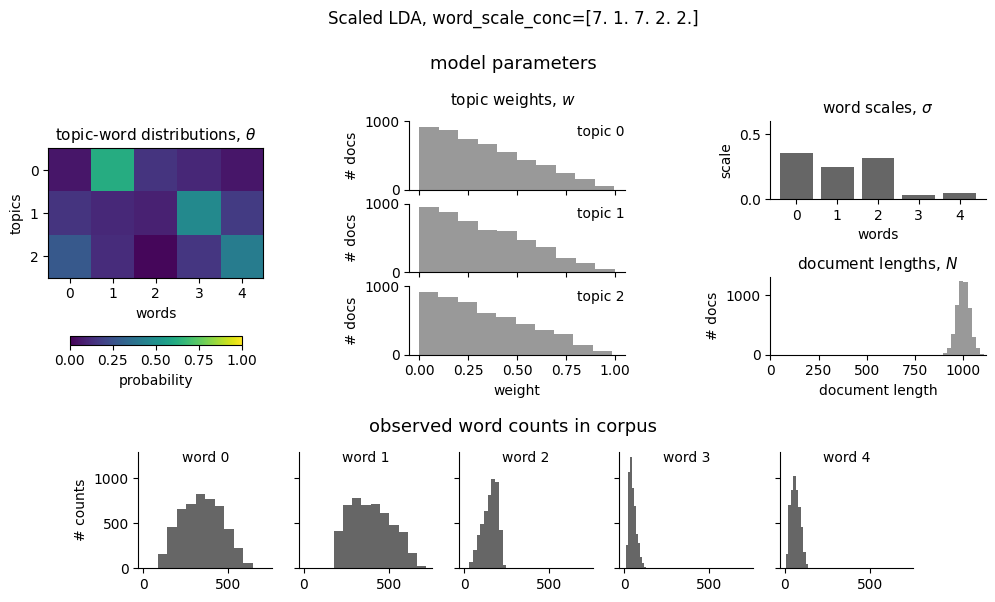

In [6]:
def plot_model_param_and_data(params: Params, data: Array):
    subfig_title_size = 13
    subfig_title_y = 1.1
    subplot_title_size = 11

    fig = plt.figure(figsize=(10,5))
    subfigs = fig.subfigures(2, 1, height_ratios=[2,1], hspace=0.2)

    # ===========================
    # Row 1: Model params
    # ===========================
    subfigs[0].suptitle('model parameters', y=subfig_title_y, fontsize=subfig_title_size)
    param_subfigs = subfigs[0].subfigures(1, 3, wspace=0.3)

    # ---------------------------
    # Topics
    # ---------------------------
    ax = param_subfigs[0].subplots()

    im = ax.imshow(params.topics, vmin=0, vmax=1)
    plt.colorbar(
        im, ax=ax, label='probability', location='bottom', pad=0.25, fraction=0.08, shrink=0.8
    )

    ax.set_xlabel('words'); ax.set_xticks(range(vocab_size))
    ax.set_ylabel('topics'); ax.set_yticks(range(n_topics))
    ax.set_title(r'topic-word distributions, $\theta$', fontsize=subplot_title_size)

    # ---------------------------
    # Weights
    # ---------------------------
    axs = param_subfigs[1].subplots(n_topics, sharex='all', sharey='all')
    for k, ax in enumerate(axs):
        ax.hist(params.weights[:,k], fc='0.6')
        ax.text(1, 0.95, f"topic {k}", transform=ax.transAxes, ha='right', va='top')
        ax.set_ylabel('# docs')
        sns.despine(ax=ax)
        
    axs[-1].set_xlabel('weight')
    param_subfigs[1].suptitle(r'topic weights, $w$', fontsize=subplot_title_size)

    # ---------------------------
    # Word scales and doc lengths
    # ---------------------------
    axs = param_subfigs[2].subplots(2, gridspec_kw={'hspace': 1.0})

    ax = axs[0]
    ax.bar(range(vocab_size), params.scales, fc='0.4')
    ax.set_xlabel('words'); ax.set_xticks(range(vocab_size))
    ax.set_ylabel("scale"); ax.set_ylim(top=3/vocab_size)
    sns.despine(ax=ax)
    ax.set_title(r'word scales, $\sigma$', fontsize=subplot_title_size)

    ax = axs[1]
    ax.hist(data.sum(axis=-1), fc='0.6')
    ax.set_xlabel('document length')
    ax.set_xlim(left=0)
    ax.set_ylabel('# docs')
    sns.despine(ax=ax)
    ax.set_title(f'document lengths, $N$', fontsize=subplot_title_size)

    # ===========================
    # Row 2: Word usage counts
    # ===========================
    ncols = 5
    nrows = vocab_size // ncols + (vocab_size % ncols)

    subfigs[1].suptitle('observed word counts in corpus', y=subfig_title_y, fontsize=subfig_title_size)
    axs = subfigs[1].subplots(nrows, ncols, sharex='all', sharey='all')

    for v, ax in enumerate(axs.ravel()):
        ax.hist(data[:,v], fc='0.4')
        ax.text(0.5, 0.95, f"word {v}", transform=ax.transAxes, ha='center', va='center')
        sns.despine(ax=ax)
    axs[0].set_ylabel('# counts')

    return fig

# ----------------------------------------------------------------------------------------
fig = plot_model_param_and_data(true_params, data)
fig.suptitle(f'Scaled LDA, word_scale_conc={true_pparams.scale_conc}', y=1.15)

**Figure.** Model parameters and observed word counts of scaled LDA model.
The `word_scale_conc` concentrations are explicitly set to be adversarial:
We see that topic 1 has large mass on word 1, but word 1 makes up a significantly less fraction of observed words
than, for example, words 2, 3, and 4.

### Infer parameters with variational Bayes

In [7]:
# Infer with variational Bayes (VB)
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_topics,)

lda.fit(data)

topics=lda.components_ / lda.components_.sum(axis=1, keepdims=True)
weights=lda.transform(data)

# ----------------------------------------------------------------------
# Permute VB topics to best match data-generating topics.
# Use Jensen-Shannon divergence (smoothed and symmetrized version of KL div,
# bounded between 0 and 1). Good enough for our purposes
cost_matrix = cdist(true_params.topics, topics, metric='jensenshannon')
_, i_permute = linear_sum_assignment(cost_matrix)

vb_params = Params(
    topics = topics[i_permute],
    weights = weights[:,i_permute],
)

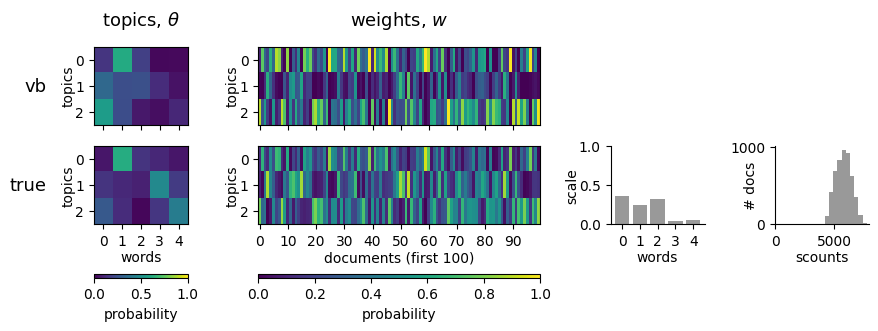

In [8]:
def compare_params(params_dict):
    n_params = len(true_params)
    n_sets = len(params_dict)

    fig, all_axs = plt.subplots(
        nrows=n_sets+2, height_ratios=(1,)*n_sets + (0.1,0.05),
        ncols=n_params, width_ratios=(1,3,1,1),
        gridspec_kw={"hspace": 0.5, "wspace": 0.5},
        figsize=(10,len(params_dict)+1)
    )

    # Second to last axis is just to a buffer pad
    for ax in all_axs[-2]:
        ax.remove()

    # ======================================================
    # Topics (heatmap)
    # ======================================================
    i_col = 0
    axs, cax = all_axs[:-2,i_col], all_axs[-1,i_col]

    for ax, params in zip(axs, params_dict.values()):
        im = ax.imshow(params.topics, vmin=0, vmax=1, aspect="auto")
        ax.set_xticks(range(vocab_size)); ax.tick_params(labelbottom=False)
        ax.set_ylabel("topics", labelpad=0); ax.set_yticks(range(n_topics))
    ax.set_xlabel("words", labelpad=2); ax.tick_params(labelbottom=True)

    # Show colorbar
    plt.colorbar(im, cax=cax, location='bottom', label='probability')

    # ======================================================
    # Weights (heatmap)
    # ======================================================
    i_col = 1
    axs, cax = all_axs[:-2,i_col], all_axs[-1,i_col]

    n = 100
    for ax, params in zip(axs, params_dict.values()):
        im = ax.imshow(params.weights[:n].T, vmin=0, vmax=1, aspect="auto", interpolation="none")
        
        ax.set_xticks(jnp.linspace(0, n, num=min(10, n), endpoint=False)); ax.tick_params(labelbottom=False)
        ax.set_ylabel("topics", labelpad=0); ax.set_yticks(range(n_topics))

    ax.set_xlabel(f"documents (first {n})", labelpad=2); ax.tick_params(labelbottom=True)
    plt.colorbar(im, cax=cax, location='bottom', label='probability')

    # ======================================================
    # Scales (bar plot)
    # ======================================================
    i_col = 2
    axs, cax = all_axs[:-2,i_col], all_axs[-1,i_col]
    cax.remove()  # no colorbar needed

    for ax, params in zip(axs, params_dict.values()):
        if params.scales is None:
            ax.remove()
        else:
            ax.bar(range(vocab_size), params.scales, fc='0.6')
            ax.set_xticks(range(vocab_size)); ax.tick_params(labelbottom=False)
            ax.set_ylim(0,1)
            ax.set_ylabel("scale", labelpad=0)
            sns.despine(ax=ax)

    ax.set_xlabel(f"words", labelpad=2); ax.tick_params(labelbottom=True)

    # ======================================================
    # Scounts (histogram)
    # ======================================================
    i_col = 3
    axs, cax = all_axs[:-2,i_col], all_axs[-1,i_col]
    cax.remove()  # no colorbar needed

    ymax = 0
    for ax, params in zip(axs, params_dict.values()):
        if params.scounts is None:
            ax.remove()
        else:
            ax.hist(params.scounts, fc='0.6')
            ax.tick_params(labelbottom=False)
            ax.set_xlim(left=0)
            sns.despine(ax=ax)
            ax.set_ylabel("# docs", labelpad=-20.)
            ymax = max(ymax, ax.get_ylim()[1])
    
    for ax, params in zip(axs, params_dict.values()):
        if params.scounts is not None:
            ax.set_ylim(top=ymax)

    ax.set_xlabel(f"scounts", labelpad=2); ax.tick_params(labelbottom=True)

    # ======================================================
    # Super-labels
    # ======================================================
    # Rows: Parameter set name
    for ax, name in zip(all_axs[:-2,0], params_dict.keys()):
        ax.text(-0.5, 0.5, name, ha='right', va='center', fontsize=13, transform=ax.transAxes)

    # Columns: Parameter names
    for ax, name in zip(all_axs[0], [r"topics, $\theta$", r"weights, $w$", r"scales, $\sigma$", r"scounts, $c$"]):
        ax.text(0.5, 1.2, name, ha='center', va='bottom', fontsize=13, transform=ax.transAxes)

compare_params({
    "vb": vb_params,
    "true": true_params,
})

**Figure** Inference under the standard LDA model using variational Bayes does not recover the data-generating topics.
Instead, it places (relatively) too much mass on words 3 and 4, which make up a significant portion of observed word counts.

### Infer parameters with EM and PGD

We compute the E-step as usual. For the M-step, we use the PGD algorithm. This should exactly calculate the maximizing values because the parameters should already lie in the simplex.

#### E-step

In [32]:
def e_step(data: Array, params: Params) -> PParams:
    """Compute posterior expected sufficient statistics of parameters.

    Parameters
    ----------
    X: data tensor, shape (M,V)
    params: namedtuple of parameters
        weights: shape (M,K)
        topics: shape (K,V)
        scales: shape (V,)
        scounts: shape (M,)

    Returns
    -------
    expected_params
    """

    topics, weights, scales, scounts \
        = jax.tree.map(lambda arr: jnp.clip(arr, min=1e-4), params)

    # Compute expected likelihood
    rhos = scales * jnp.einsum('mk, kv -> mkv', weights, topics)
    rhos /= (rhos.sum(axis=1, keepdims=True))
    ezs = data[:,None,:] * rhos  # shape (M,K,V)

    # Compute expected params
    topic_conc = ezs.sum(axis=0)
    topic_rate = jnp.einsum('m,v,mk->kv', scounts, scales, weights)

    weight_conc = ezs.sum(axis=-1)
    weight_rate = jnp.einsum('m,v,kv->mk', scounts, scales, topics)

    scale_conc = ezs.sum(axis=(0,1))
    scale_rate = jnp.einsum('m,mk,kv->v', scounts, weights, topics)

    scount_conc = ezs.sum(axis=(1,2))
    scount_rate = jnp.einsum('v,mk,kv->m', scales, weights, topics)

    return PParams(
        topic_conc=topic_conc,
        topic_rate=topic_rate,
        weight_conc=weight_conc,
        weight_rate=weight_rate,
        scale_conc=scale_conc,
        scale_rate=scale_rate,
        scount_conc=scount_conc,
        scount_rate=scount_rate,
    )

# ------------------------------------------------
# sanity check: make sure it runs without error
true_eparams = e_step(data, true_params)

#### M-step

In [11]:
max_num_steps = 100
max_stepsize = 1e-5

objective = lambda x, shapes, rates: \
    -1.0 * tfd.Gamma(shapes, rate=rates).log_prob(jnp.clip(x, a_min=1e-4)).mean()

def gamma_dirichlet_pgd(init_param, alpha, beta):
    return prox_grad_descent(
        lambda x: objective(x, alpha, beta),
        project_simplex,
        init_param,
        max_num_steps=max_num_steps,
        max_stepsize=max_stepsize
    )

In [28]:
def m_step(params: Params, expct_params: PParams, prior_params: PParams) -> Params:
    
    topics, weights, scales, scounts = params

    # Update topics
    conc_ = expct_params.topic_conc + prior_params.topic_conc
    rate_ = expct_params.topic_rate + prior_params.topic_rate
    topics = vmap(gamma_dirichlet_pgd)(topics, conc_, rate_)

    # Update weights
    conc_ = expct_params.weight_conc + prior_params.weight_conc
    rate_ = expct_params.weight_rate + prior_params.weight_rate
    weights = vmap(gamma_dirichlet_pgd)(weights, conc_, rate_)

    # Update scales
    conc_ = expct_params.scale_conc + prior_params.scale_conc
    rate_ = expct_params.scale_rate + prior_params.scale_rate
    scales = gamma_dirichlet_pgd(scales, conc_, rate_)

    # Update scounts - no PGD require
    conc_ = expct_params.scount_conc + prior_params.scount_conc
    rate_ = expct_params.scount_rate + prior_params.scount_rate
    scounts = conc_ / rate_

    return Params(topics, weights, scales, scounts)



We find that the fitted params can recover the true params.

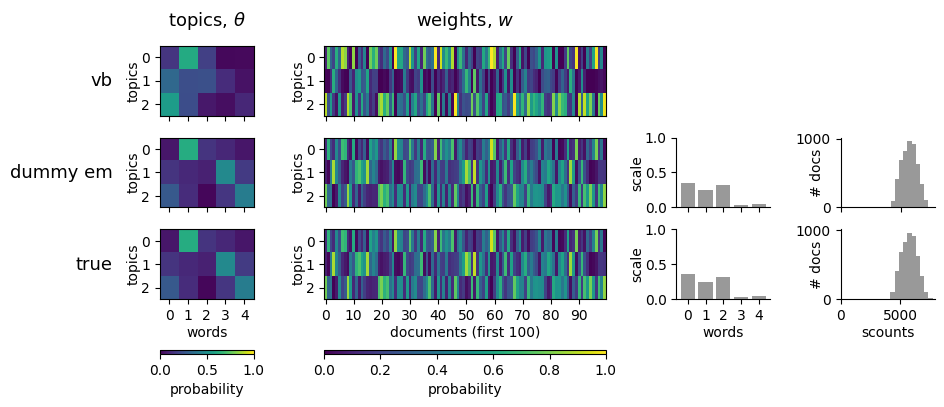

In [13]:
uninf_pparams = PParams()  # use default values
dummy_params = m_step(true_params, true_eparams, uninf_pparams)

compare_params({
    "vb": vb_params,
    "dummy em": dummy_params,
    "true": true_params,
})

Now, let's make it ever so slightly harder by starting from randomly initialized parameters.

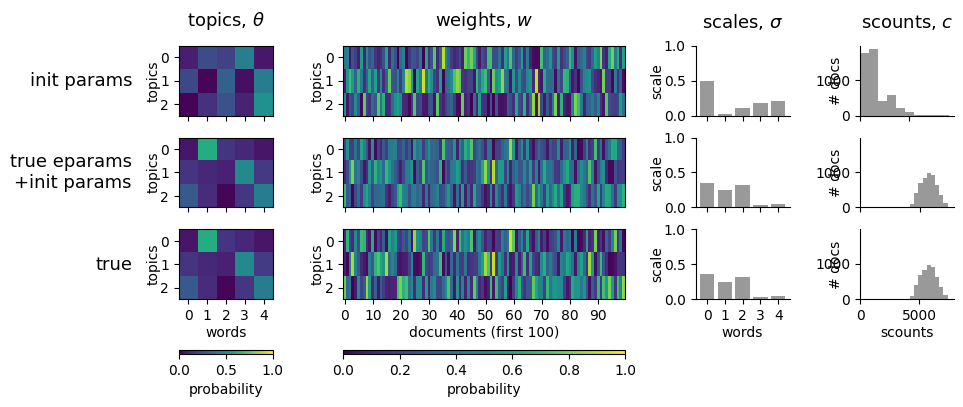

In [14]:
true_eparams = e_step(data, true_params)
uninf_pparams = PParams()  # use default values
init_params, _ = sample_params_and_data(jr.key(0), n_topics, vocab_size, n_docs, uninf_pparams)
dummy_params = m_step(init_params, true_eparams, uninf_pparams)

compare_params({
    "init params": init_params,
    "true eparams\n+init params": dummy_params,
    "true": true_params,
})

### Fit all but 1 parameter

Let's try incrementally harder, giving true values for one parameter at a time and asking algo to infer all others

**Learn topics**

all close? True


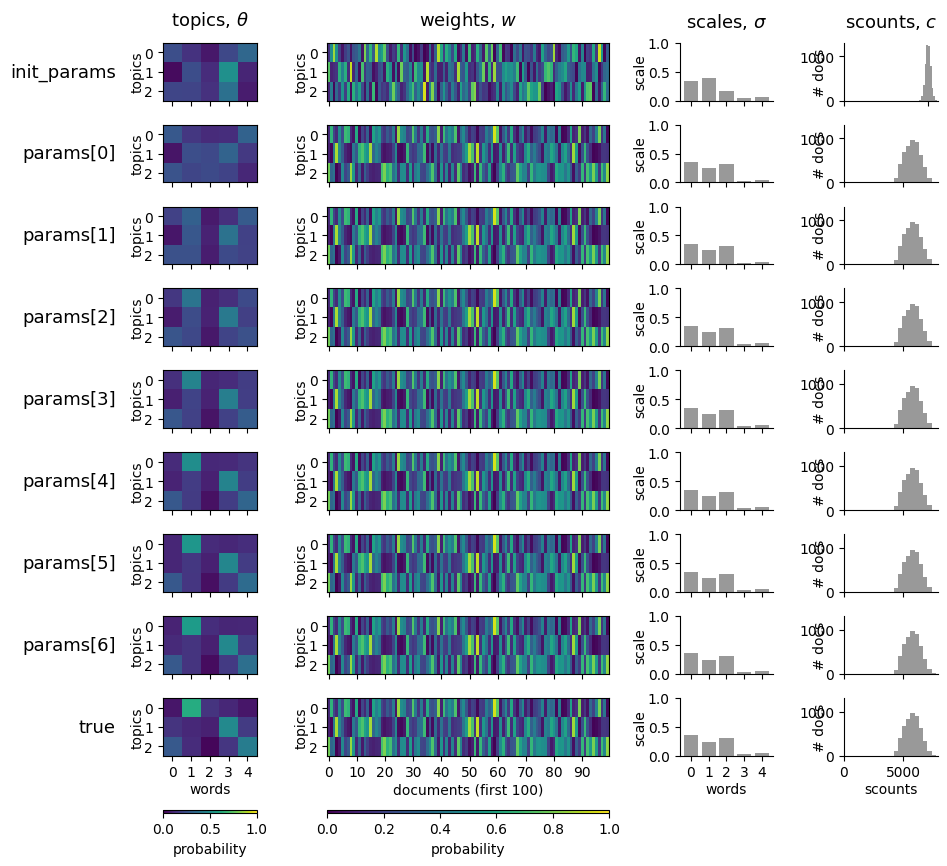

In [15]:
def em(data:Array, params: Params, prior_params: PParams, max_em_steps: int=10):
    nlls, all_params = [], []
    
    for _ in range(max_em_steps):
        expct_params = e_step(data, params)

        # Update topics
        conc_ = expct_params.topic_conc + prior_params.topic_conc
        rate_ = expct_params.topic_rate + prior_params.topic_rate
        topics = vmap(gamma_dirichlet_pgd)(params.topics, conc_, rate_)

        params = Params(topics, true_params.weights, true_params.scales, true_params.scounts)
        all_params.append(params)
    
    return all_params, nlls

# Let's a be a little smart / make use of the observations to set initial params
uninf_pparams = PParams()
(topics, weights, scales, scounts), _ = sample_params_and_data(jr.key(1), n_topics, vocab_size, n_docs, uninf_pparams)
init_params = Params(
    topics, weights,
    scales=jnp.median(data, axis=0) / jnp.median(data, axis=0).sum(),
    scounts=data.sum(axis=-1)*vocab_size,
)

all_params, _ = em(data, init_params, uninf_pparams, max_em_steps=7)

print("all close?", jnp.allclose(true_params.topics, all_params[-1].topics, atol=5e-2, rtol=1e-1))

compare_params({
    "init_params": init_params,
    **{f"params[{i}]": params_ for i, params_ in enumerate(all_params)},
    "true": true_params,
})

**Learn weights**

all close? False


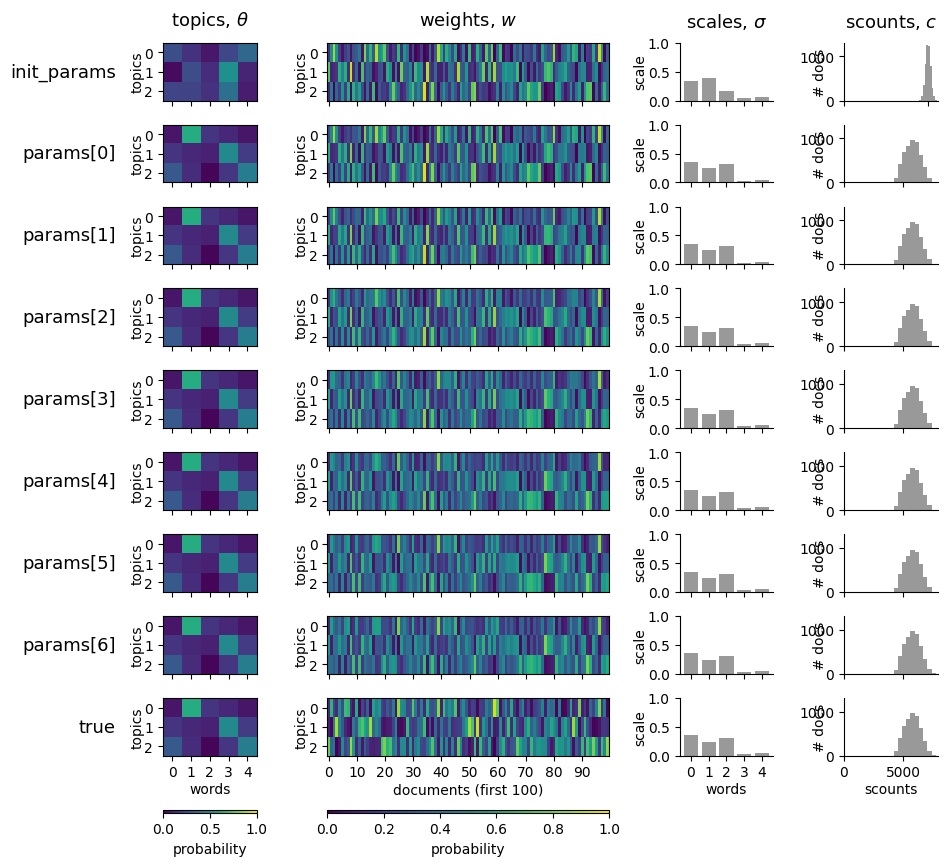

In [16]:
def em(data:Array, params: Params, prior_params: PParams, max_em_steps: int=10):
    nlls, all_params = [], []
    
    for _ in range(max_em_steps):
        expct_params = e_step(data, params)

        # Update weights
        conc_ = expct_params.weight_conc + prior_params.weight_conc
        rate_ = expct_params.weight_rate + prior_params.weight_rate
        weights = vmap(gamma_dirichlet_pgd)(params.weights, conc_, rate_)

        params = Params(true_params.topics, weights, true_params.scales, true_params.scounts)
        all_params.append(params)
    
    return all_params, nlls

# Let's a be a little smart / make use of the observations to set initial params
uninf_pparams = PParams()
(topics, weights, scales, scounts), _ = sample_params_and_data(jr.key(1), n_topics, vocab_size, n_docs, uninf_pparams)
init_params = Params(
    topics, weights,
    scales=jnp.median(data, axis=0) / jnp.median(data, axis=0).sum(),
    scounts=data.sum(axis=-1)*vocab_size,
)

all_params, _ = em(data, init_params, uninf_pparams, max_em_steps=7)

print("all close?", jnp.allclose(true_params.weights, all_params[-1].weights, atol=5e-2, rtol=1e-1))

compare_params({
    "init_params": init_params,
    **{f"params[{i}]": params_ for i, params_ in enumerate(all_params)},
    "true": true_params,
})

**Learn scales**

True


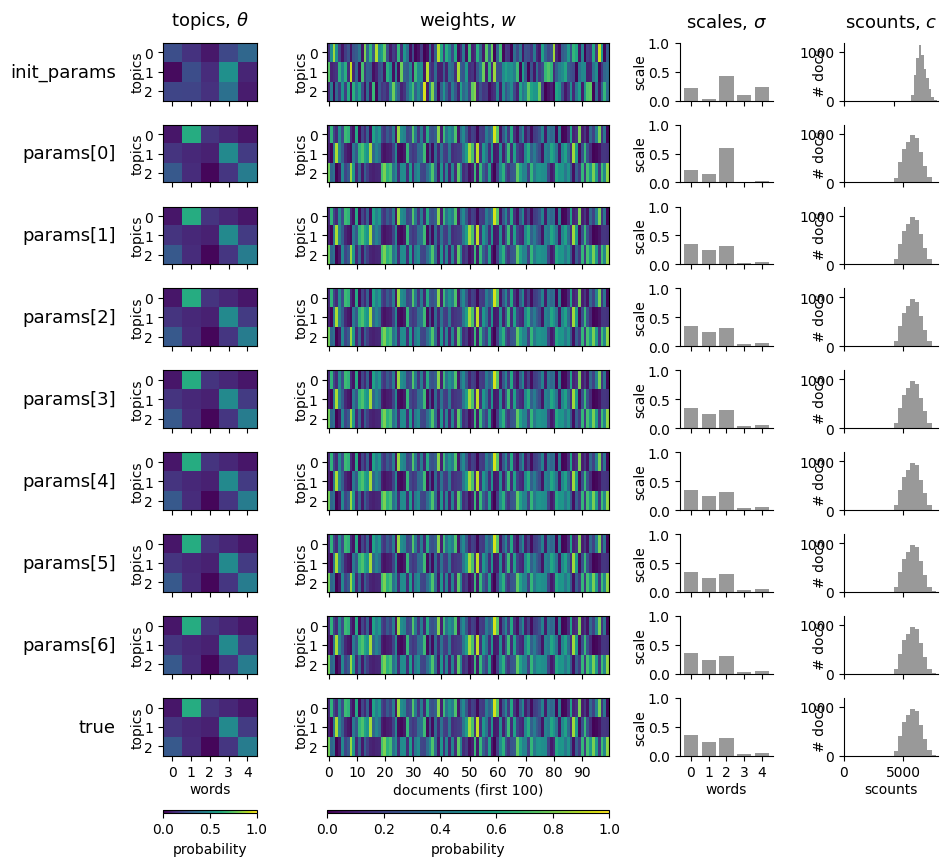

In [46]:
def em(data:Array, params: Params, prior_params: PParams, max_em_steps: int=10):
    nlls, all_params = [], []
    
    for _ in range(max_em_steps):
        expct_params = e_step(data, params)

        # Update scales
        conc_ = expct_params.scale_conc + prior_params.scale_conc
        rate_ = expct_params.scale_rate + prior_params.scale_rate
        scales = gamma_dirichlet_pgd(params.scales, conc_, rate_)

        params = Params(true_params.topics, true_params.weights, scales, true_params.scounts)
        all_params.append(params)
    
    return all_params, nlls

# don't be smart about initializing the scales, see if it can learn it
uninf_pparams = PParams(scount_conc=data.sum(axis=-1).mean()*vocab_size)
init_params, _ = sample_params_and_data(jr.key(1), n_topics, vocab_size, n_docs, uninf_pparams)

all_params, _ = em(data, init_params, uninf_pparams, max_em_steps=7)
assert jnp.allclose(true_params.scales, all_params[-1].scales, atol=1e-3, rtol=1e-1)

compare_params({
    "init_params": init_params,
    **{f"params[{i}]": params_ for i, params_ in enumerate(all_params)},
    "true": true_params,
})

**Learn scounts**

all close? True


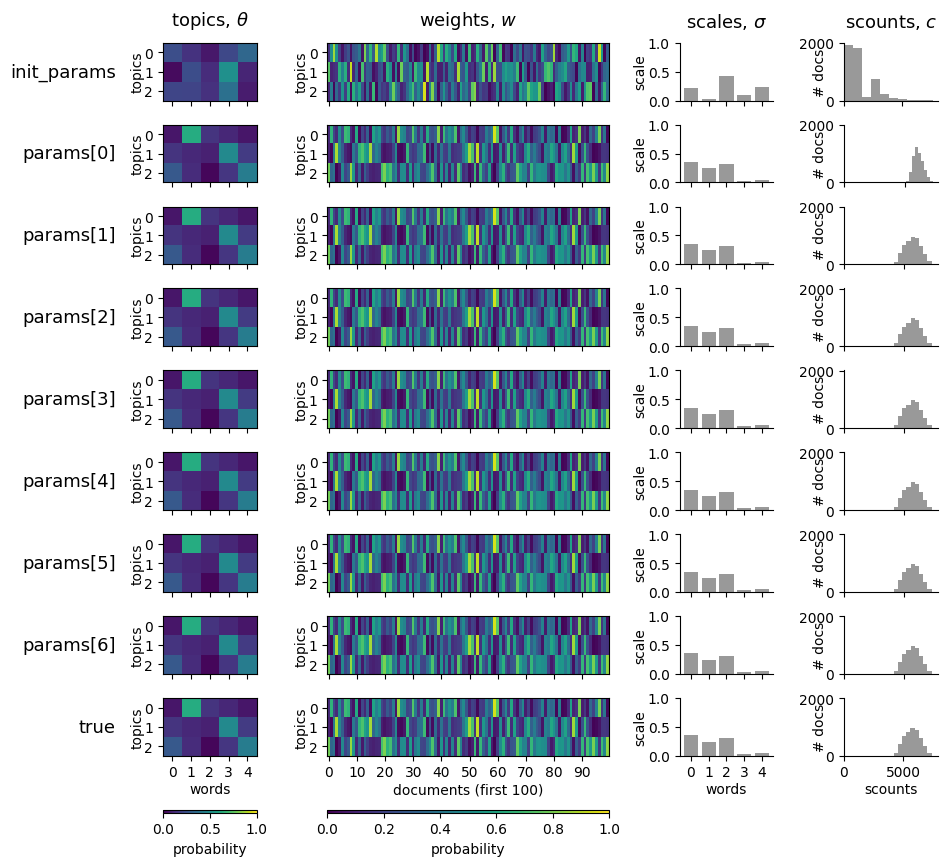

In [26]:
def em(data:Array, params: Params, prior_params: PParams, max_em_steps: int=10):
    nlls, all_params = [], []
    
    for _ in range(max_em_steps):
        expct_params = e_step(data, params)

        # Update scounts - no PGD require
        conc_ = expct_params.scount_conc + prior_params.scount_conc  # this change made a big diff!
        rate_ = expct_params.scount_rate + prior_params.scount_rate
        scounts = conc_ / rate_

        params = Params(true_params.topics, true_params.weights, true_params.scales, scounts)
        all_params.append(params)
    
    return all_params, nlls

uninf_pparams = PParams()
init_params, _ = sample_params_and_data(jr.key(1), n_topics, vocab_size, n_docs, uninf_pparams)

all_params, _ = em(data, init_params, uninf_pparams, max_em_steps=7)

print("all close?", jnp.allclose(true_params.scounts, all_params[-1].scounts, atol=5e-2, rtol=1e-1))

compare_params({
    "init_params": init_params,
    **{f"params[{i}]": params_ for i, params_ in enumerate(all_params)},
    "true": true_params,
})

## Fit all but two

### Finally, let's try EM from scratch

In [35]:
nll_fn = (lambda params, data:
    -1.0 * tfd.Poisson(
        jnp.einsum('m,v,mk,kv->mv', params.scounts, params.scales, params.weights, params.topics)
    ).log_prob(jnp.clip(data, a_min=1e-4)).mean()
)  # actually, this is just the nll

def em(data:Array, params: Params, pparams: PParams, max_em_steps: int=10):
    nlls, all_params = [], []
    
    for _ in range(max_em_steps):
        eparams = e_step(data, params)
        params = m_step(params, eparams, pparams)
        nll = nll_fn(params, data)

        nlls.append(nll)
        all_params.append(params)

    # lax.scan doesn't obviously speed things up.
    # def em_step(params, x):
    #     eparams = e_step(data, params)
    #     params = m_step(params, eparams, pparams)
    #     nll = nll_fn(params, data)
    #     return params, (params, nll)
        
    # _, (all_params, nlls) = jax.lax.scan(em_step, params, length=max_em_steps)
    
    return all_params, nlls

# Let's be smart / make use of the observations to set initial parameters
uninf_pparams = PParams()
# (topics, weights, _, _), _ = sample_params_and_data(jr.key(1), n_topics, vocab_size, n_docs, uninf_pparams)

s1, s2 = jr.split(jr.key(1))
init_params = Params(
    topics=jr.dirichlet(s1, 1.001*jnp.ones(vocab_size), (n_topics,)),
    weights=jr.dirichlet(s2, 1.001*jnp.ones(n_topics), (n_docs,)),
    scales=jnp.median(data, axis=0) / jnp.median(data, axis=0).sum(),
    scounts=data.sum(axis=-1),
)


all_params, nlls = em(data, init_params, uninf_pparams, max_em_steps=20)

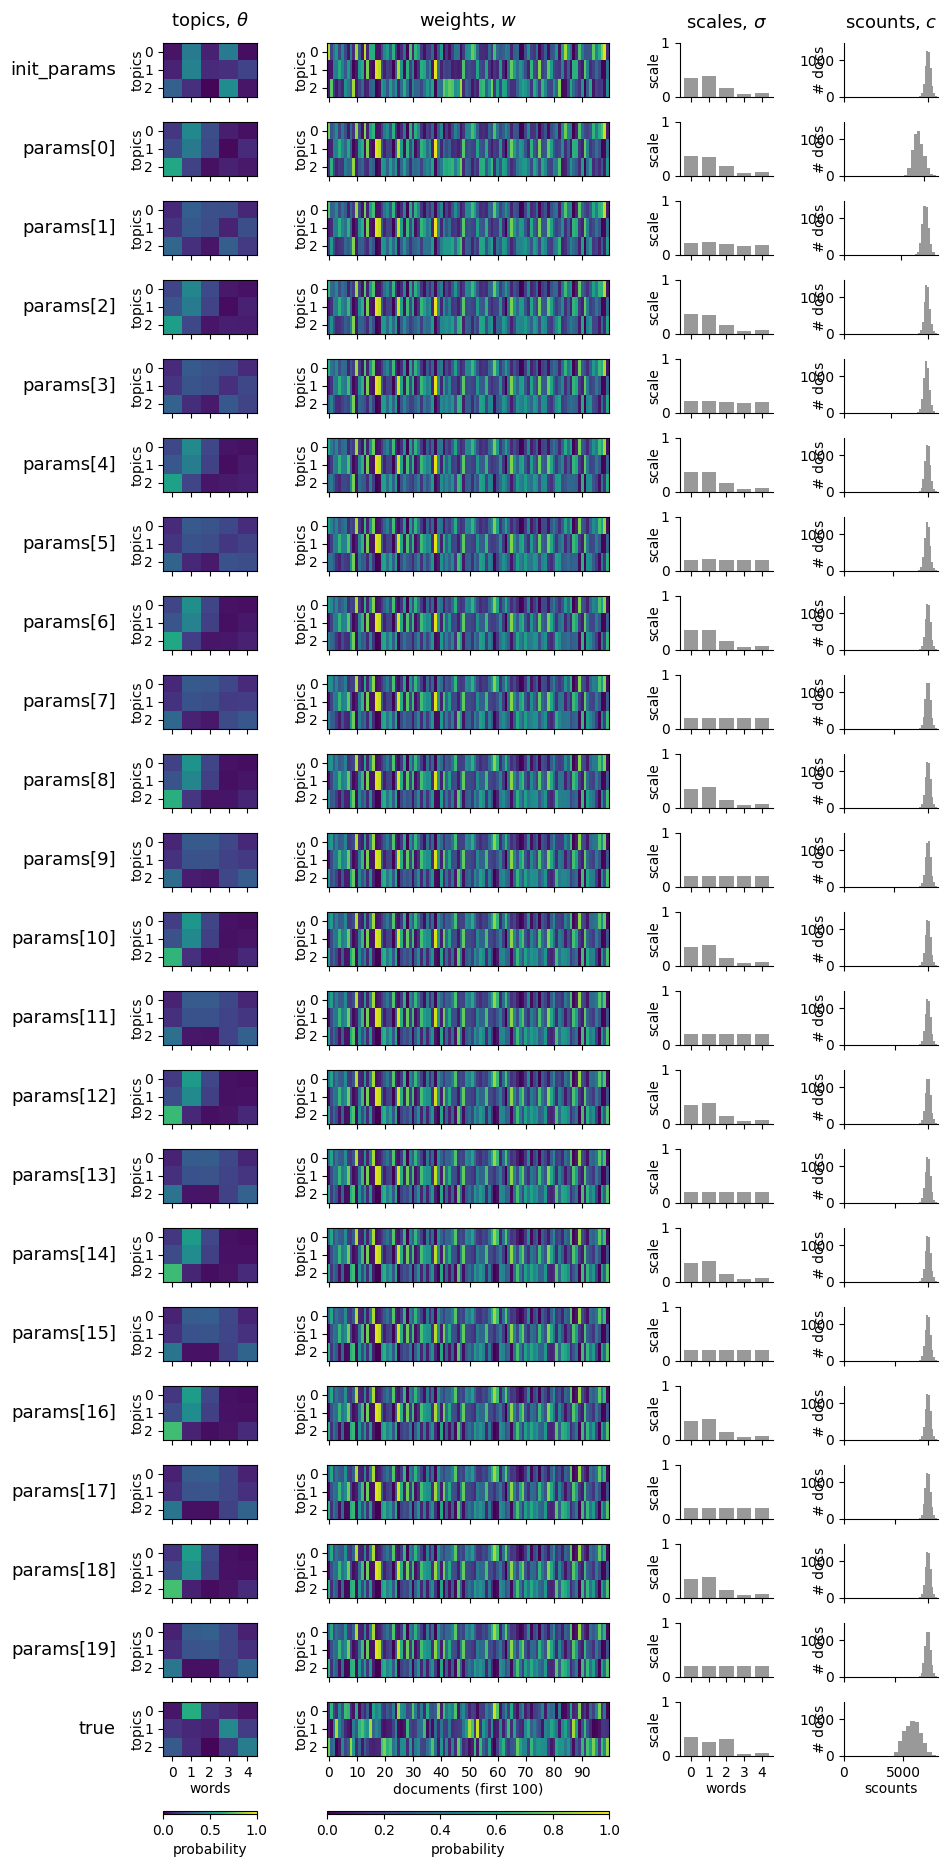

In [36]:
compare_params({
    "init_params": init_params,
    **{f"params[{i}]": params_ for i, params_ in enumerate(all_params)},
    "true": true_params,
})